Import The Library

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import joblib 

from sklearn import svm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D

# Manage Working Directory For ImageDataGenerator

In [ ]:
train_dir = os.path.join(os.getcwd(), 'Dataset/train_data')
print(train_dir)

valid_dir = os.path.join(os.getcwd(), 'Dataset/valid_data')
print(valid_dir)

test_dir = os.path.join(os.getcwd(), 'Dataset/test_data')
print(test_dir)

# Create ImageGenerator and Preprocessing

To use the code bellow, you have to generate image based on the CNN or SVM needs. One thing you have to make sure is the "target_size". Change it based on the input of CNN Model size

In [ ]:
#Image Generator for Training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

print("--------------Training Data--------------")
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    shuffle = True,
    seed = 42,
    target_size = (24,24),
    color_mode= "grayscale",
    #batch_size= 32,
    class_mode= "binary"
)
print("Image shape = ", train_generator.image_shape)

#Image Generator for Validating
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

print("\n--------------Validation Data--------------")
valid_generator = valid_datagen.flow_from_directory(
    directory = valid_dir,
    shuffle = True,
    target_size = (24,24),
    color_mode= "grayscale",
    #batch_size= 32,
    class_mode= "binary",
    seed = 42,
)
print("Image shape = ", valid_generator.image_shape)

#Image Generator for testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

print("\n--------------Test Data--------------")
test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    shuffle = False,
    target_size = (24,24),
    color_mode= "grayscale",
    #batch_size= 32,
    class_mode= "binary",
    seed = 42,
)
print("Image shape = ", test_generator.image_shape)

# Define Step per Epoch and Validation Step
batch_size = 32
SPE = len(train_generator.classes)//batch_size
VS = len(valid_generator.classes)//batch_size 

# SVM

### feature Extraction for SVM

In [7]:
#Extraction for Training 
x_train, y_train = [],[]
for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    x_train.extend(batch_x)
    y_train.extend(batch_y)
    
X = np.array(x_train)
y = np.array(y_train)
X = X.reshape(X.shape[0],-1)

#Extraction for Training 
x_test, y_test = [],[]
for i in range(len(test_generator)):
    batch_x, batch_y = test_generator[i]
    x_test.extend(batch_x)
    y_test.extend(batch_y)
    
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],-1)

### Training SVM using Split validation Method

On the Code Bellow, the default kernel used is 'sigmoid'. Just change the kernel ini svm.SVC to use different kernel. For example, Poly to use polynomial kernel

In [19]:
clf = svm.SVC(kernel='sigmoid')

# Train the SVM model on the training data
clf.fit(X, y)

# Predict labels for the training and validation sets
y_train_pred = clf.predict(X)
y_val_pred = clf.predict(x_test)

# Calculate and print training accuracy
train_accuracy = accuracy_score(y, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Calculate and print validation accuracy
val_accuracy = accuracy_score(y_test, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 0.6666666666666666
Validation Accuracy: 0.5


### Saving trained model 



In [18]:
# change the path to save it depend on the kernel you use. The default will be in sigmoid folder
os.chdir("Training Results/SVM/Sigmoid")

results = {
    "Train_Accuracies": train_accuracy,
    "Validation_Accuracies": val_accuracy,
}

model_filename = "svm_poly_split.pkl"
joblib.dump(clf, model_filename)

np.save('svm_poly_split.npy', results)

### Training SVM Model using Stratified k-fold or repeated k-fold cross validation

On the Code Bellow, the default kernel used is 'rbf'. Just change the kernel ini svm.SVC to use different kernel. For example, Poly to use polynomial kernel

In [ ]:
# Create an SVM model
svm_model = svm.SVC(kernel='rbf')

# Create Stratified K-Fold Cross Validator
stratified_kfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

# Create Repeated Stratified K-Fold Cross Validator
repeated_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Lists to store accuracy scores for each fold
train_accuracies = []
validation_accuracies = []

# Perform Stratified K-Fold Cross Validation. change the 'stratified_kfold' to 'repeated_kfold' if you want to perform another method
for train_index, val_index in stratified_kfold.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train the model
    svm_model.fit(X_train, y_train)

    # Predictions on training set
    train_predictions = svm_model.predict(X_train) 
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_accuracies.append(train_accuracy)

    # Predictions on validation set
    val_predictions = svm_model.predict(X_val)
    validation_accuracy = accuracy_score(y_val, val_predictions)
    validation_accuracies.append(validation_accuracy)

# Print the results
print(f"Train Accuracies: {train_accuracies}")
print(f"Validation Accuracies: {validation_accuracies}")
print(f"Mean Train Accuracy: {np.mean(train_accuracies)}")
print(f"Mean Validation Accuracy: {np.mean(validation_accuracies)}")

### saving the trained model and trainig result 

In [126]:
os.chdir("Training Results/SVM/Rbf")

results = {
    "Train_Accuracies": train_accuracies,
    "Validation_Accuracies": validation_accuracies,
    "Mean_Train_Accuracy": np.mean(train_accuracies),
    "Mean_Validation_Accuracy": np.mean(validation_accuracies)
}

model_filename = "svm_rbf_stratifiedKF.pkl"
joblib.dump(svm_model, model_filename)

np.save('svm_rbf_stratifiedKF.npy', results)

## Showing the Confusion Matrix of SVM MOdel

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# change the directory to model directory you want. Default as polynomial kernel, using split validation method
my_model = joblib.load(
    'Training Results/SVM/Polynomial/svm_poly_split.pkl')

# Predict classes
y_pred = my_model.predict(x_test)

# Evaluating Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy}')

print('Confusion Matrix')
confusion_matrix = confusion_matrix(test_generator.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['Closed Eye', 'Open Eye']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# Display the Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = target_names)

cm_display.plot()
plt.title("Confusion Matrix, kernel = polynomial")
plt.show()

### Showing the ROC Graph of SVM model

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)

# Calculate AUC score
auc = roc_auc_score(test_generator.classes, y_pred)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(' Grafik ROC,  SVM Polynomial')
plt.legend(loc='lower right')
plt.show()

# CNN Model 

Model CNN-1

In [ ]:
modelCNN_1 = Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape = (24,24,1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = "relu"),
    Dropout(0.5),
    Flatten(),
    Dropout(0.3),
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(4, activation = "relu"),
    Dropout(0.3),
    Dense(1, activation = "sigmoid")
])

modelCNN_1.summary()

Model CNN-2

In [ ]:
modelCNN_2 = Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape = (24,24,1)),
    AveragePooling2D((2,2)),
    Conv2D(32, (3,3), activation = "relu"),
    AveragePooling2D((2,2)),
    Conv2D(64, (3,3), activation = "relu"),
    AveragePooling2D((2,2)),
    Flatten(),
    Dense(128, activation = "relu"),
    Dense(84, activation = "relu"),
    Dense(1, activation = "sigmoid")
])

modelCNN_2.summary()

Model CNN-3

In [ ]:
modelCNN_3 = Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape = (30,30,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.3),
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(1, activation = "sigmoid")
])

modelCNN_3.summary()

Model CNN-4

In [ ]:
myModel = Sequential([
    Conv2D(64, (3,3), activation = "relu", input_shape = (86,86,1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),
    Conv2D(16, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),
    Conv2D(16, (3,3), activation = "relu"),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(64, activation = "relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])

myModel.summary()

### Compile and Fit/train Model

Change the modelCNN_1 to the Model you use. For example if you want to use CNN Model 3, change it to 'modelCNN_3'

In [ ]:
# compile the model
modelCNN_1.compile(
    loss= "binary_crossentropy",
    optimizer= "adam",
    metrics= ["accuracy"]
)

# traing the model and save the training results to a variable called history
history = modelCNN_1.fit(
                train_generator,
                steps_per_epoch= SPE,
                validation_data= valid_generator,
                validation_steps= VS,
                epochs=150,
            )

# Saving the trained Model and its metric values

Change the modelCNN_1 to the model you used on training.

In [8]:
modelCNN_1.save("Training Results/CNN Model-2/750 Epoch/modelCNN_2_75Epoch.h5")
np.save("Training Results/CNN Model-2/750 Epoch/modelCNN_2_75Epoch.npy", history)

### Showing the training accuracy and loss

Training Accuracy =  0.965499997138977
Validation Accuracy =  0.9375
Training loss =  0.10530912131071091
Validation loss =  0.19127388298511505


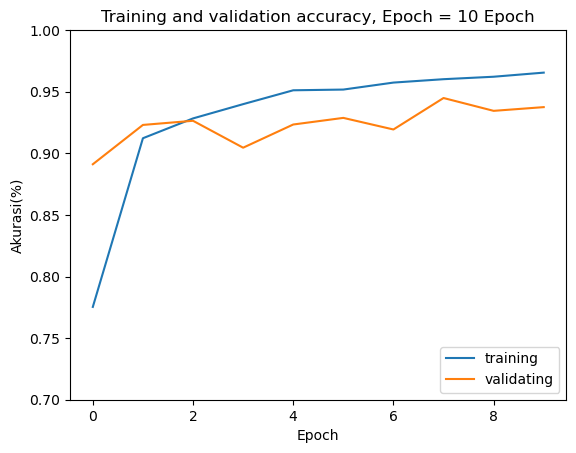

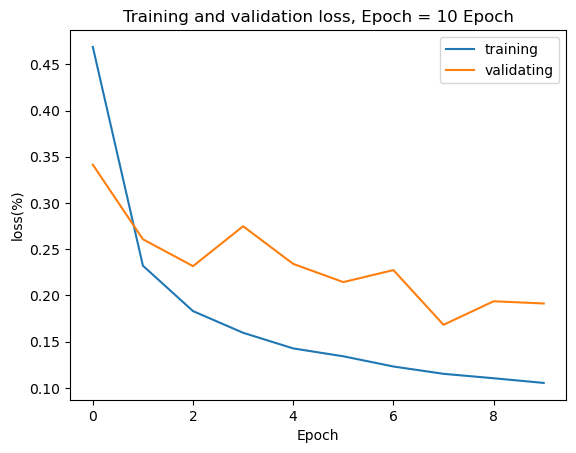

In [21]:
my_history = np.load(
    "Training Results/CNN Model-2/750 Epoch/modelCNN_2_75Epoch.np"
    ,allow_pickle='TRUE').item()

acc      = my_history[ 'accuracy' ]
val_acc  = my_history[ 'val_accuracy' ]
loss     = my_history[ 'loss' ]
val_loss = my_history[ 'val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

print("Training Accuracy = ",acc[-1])
print("Validation Accuracy = ",val_acc[-1])
print("Training loss = ",loss[-1])
print("Validation loss = ",val_loss[-1])

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'training')
plt.plot(epochs, val_acc, label = 'validating')
plt.xlabel("Epoch")
plt.ylabel("Akurasi(%)")
plt.title('Training and validation accuracy, Epoch = 150 Epoch')
plt.axis(ymin=0.7,ymax = 1.0)
plt.legend(loc = 'lower right')
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'training')
plt.plot(epochs, val_loss, label = 'validating')
plt.xlabel("Epoch")
plt.ylabel("loss(%)")
plt.title ('Training and validation loss, Epoch = 150 Epoch')
plt.legend(loc = 'upper right')
plt.show()

### Showing Confusion Matrix of the model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
#Confution Matrix and Classification Report

#Load the model 
my_model = tf.keras.models.load_model(
    'Training Results/CNN Model-2/750 Epoch/modelCNN_2_75Epoch.h5')

Y_pred = my_model.predict(test_generator)
y_pred = np.round(Y_pred).tolist()

print('Confusion Matrix')
confusion_matrix = confusion_matrix(test_generator.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['Closed Eye', 'Open Eye']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = target_names)

cm_display.plot()
plt.title("Confusion Matrix, CNN Model-1")
plt.show()

### Showing ROC Graph of the Model 

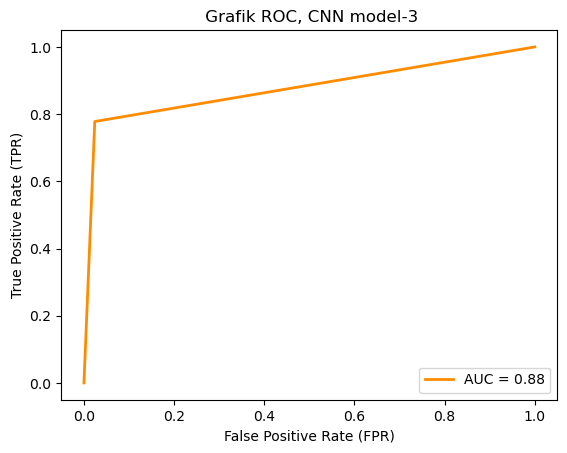

In [58]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)

# Calculate AUC score
auc = roc_auc_score(test_generator.classes, y_pred)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(' Grafik ROC, CNN model-3')
plt.legend(loc='lower right')
plt.show()


## Test the Prediction Score

In [ ]:
img_array = cv.imread("Dataset/test_data/open_eyes/s0011_01534_0_0_1_0_0_01.png") 

plt.imshow(img_array)

img_gray = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)
print("Original Shape = ", img_gray.shape)

img_resize = cv.resize(img_gray,(24, 24))
print("Resized Imaged Shape = ", img_resize.shape)

img_arr = np.array(img_resize)
print("Array Imaged Shape = ", img_arr.shape)

img_reshape = img_arr.reshape(-1, 24, 24, 1)
print("Reshaped Image Shape = ", img_reshape.shape)

x_input = img_reshape/255.0

In [ ]:
new_model = tf.keras.models.load_model('Training Results//CNN Model-2/75 Epoch/modelCNN_2_75Epoch.h5')
label = ['closed','open']

prediction = new_model.predict(x_input)
prediction_class = np.round(prediction).tolist()
print("Prediction Value = ", prediction)
#class = new_model.predict_classes(x_input)

print(prediction_class)
if prediction < 0.5 : 
    print ("eye is", label[0])
else :
    print ("eye is", label[1]) 
